## Setup

In [1]:
from google.colab import output
!pip install kaggle;
!pip install torch torchvision;
!pip install opencv-python scikit-learn;
output.clear()

In [2]:
from google.colab import files
files.upload()  # subir 1k labels
files.upload()  # mapped indices
files.upload()  # sube tu kaggle.json que tienes que descargar desde tu cuenta de kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# descargar el set al path...
!kaggle datasets download -d ambityga/imagenet100 -p /content/imagenet100 --unzip
# quedarme solo con las carpeta y archivo que importan y borrar el resto
!mv /content/imagenet100/val.X /content/val.X
!mv /content/imagenet100/Labels.json /content/Labels.json
!rm -rf /content/imagenet100

Saving mapped_indices.json to mapped_indices.json


Saving imagenet_labels.json to imagenet_labels.json


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ambityga/imagenet100
License(s): unknown
100% 16.1G/16.1G [03:16<00:00, 24.7MB/s]
100% 16.1G/16.1G [03:16<00:00, 88.0MB/s]


In [3]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

import os
import sys
import json
from tqdm import tqdm

project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms.functional import to_pil_image

import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import glob
from torch.utils.data import Dataset


In [4]:
class ImageNet100(Dataset):
    def __init__(self, root, split, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform

        with open(os.path.join(root, "Labels.json"), "rb") as f:
            json_file = json.load(f)
            self.class_to_id = {class_id[0]:idx for idx, class_id in enumerate(json_file.items())}

        samples_dir = os.path.join(root, split)

        for entry in os.listdir(samples_dir):
            target = self.class_to_id[entry]
            class_sample_path = glob.glob(f"{samples_dir}/{entry}/*")
            self.samples += class_sample_path
            self.targets += [target]*len(class_sample_path)

    def __len__(self):
            return len(self.samples)

    def __getitem__(self, idx):
            x = Image.open(self.samples[idx]).convert("RGB")
            if self.transform:
                x = self.transform(x)
            return x, self.targets[idx]

In [15]:
from torchvision.models import VGG16_Weights
from torchvision.models import ResNet50_Weights

In [16]:
device='cuda:0'

## Work Flow

In [5]:
#@title Model and dataloader
def load_model_and_dataloader(model: str, val_set: str, batch_size: int, shuffle=True):
  global device
  if model == 'vgg':
    weights = VGG16_Weights.DEFAULT
    preprocess = weights.transforms()
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

  elif model == 'resnet':
    weights = ResNet50_Weights.DEFAULT
    preprocess = weights.transforms()
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

  model.to(device)
  model.eval();

  test_data = ImageNet100('/content/', val_set, preprocess)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  return model, test_loader

In [7]:
#@title Load labels
def get_labels():
  with open("/content/imagenet_labels.json", "rb") as f:
        imgnet1k_labels = json.load(f)
        imgnet1k_labels = {int(k):v for k,v in imgnet1k_labels.items()}

  with open("/content/Labels.json", "rb") as f:
        json_file = json.load(f)
        imgnet100_labels = {idx:class_id[1] for idx, class_id in enumerate(json_file.items())}

  with open("/content/mapped_indices.json", "r") as f:
        mapped_indices = json.load(f)
        mapped_indices = {int(k): v for k, v in mapped_indices.items()}

  return imgnet1k_labels, imgnet100_labels, mapped_indices

In [9]:
_, _, mapped_indices = get_labels()
print(mapped_indices)
import json

# cargar ImageNet100 labels (subset de ImageNet1k)
with open("/content/Labels.json", "r") as f:
    imgnet100_labels = json.load(f)

# cargar todas las labels de ImageNet1k
with open("/content/imagenet_labels.json", "r") as f:
    imgnet1k_labels = json.load(f)
    imgnet1k_labels = {int(k): v for k, v in imgnet1k_labels.items()}  # Convert keys to integers

# mapear al revés imgnet1k: label (string) -> index
reverse_imgnet1k_labels = {v: k for k, v in imgnet1k_labels.items()}

# Mapear ImageNet100 class IDs a correspondienters índices de ImageNet1k
mapped_indices2 = {}
for idx, (wnid, label) in enumerate(imgnet100_labels.items()):
    if label in reverse_imgnet1k_labels:
        mapped_indices2[idx] = reverse_imgnet1k_labels[label]
    else:
        print(f"Label '{label}' not found in ImageNet1k")

# verficar si ta bien
print(mapped_indices2)
if mapped_indices == mapped_indices2:
  print("Son iguales")
else:
  print("No son iguales")

{0: 117, 1: 70, 2: 88, 3: 133, 4: 5, 5: 97, 6: 42, 7: 60, 8: 14, 9: 3, 10: 130, 11: 57, 12: 26, 13: 0, 14: 89, 15: 127, 16: 36, 17: 67, 18: 110, 19: 65, 20: 123, 21: 55, 22: 22, 23: 21, 24: 1, 25: 71, 26: 99, 27: 16, 28: 19, 29: 108, 30: 18, 31: 35, 32: 124, 33: 90, 34: 74, 35: 129, 36: 125, 37: 2, 38: 64, 39: 92, 40: 138, 41: 48, 42: 54, 43: 39, 44: 56, 45: 96, 46: 84, 47: 73, 48: 77, 49: 52, 50: 20, 51: 118, 52: 111, 53: 59, 54: 106, 55: 75, 56: 143, 57: 80, 58: 140, 59: 11, 60: 113, 61: 4, 62: 28, 63: 50, 64: 38, 65: 104, 66: 24, 67: 107, 68: 100, 69: 81, 70: 94, 71: 41, 72: 68, 73: 8, 74: 66, 75: 146, 76: 29, 77: 32, 78: 137, 79: 33, 80: 141, 81: 517, 82: 78, 83: 150, 84: 76, 85: 61, 86: 112, 87: 83, 88: 144, 89: 91, 90: 135, 91: 116, 92: 72, 93: 34, 94: 6, 95: 119, 96: 46, 97: 115, 98: 93, 99: 7}


In [ ]:
#@title Evaluar modelo
def basic_evaluate_model(model: str, val_set: str, batch_size: int):
  global device
  model, test_loader = load_model_and_dataloader(model, val_set, batch_size)
  imgnet1k_labels, imgnet100_labels, _ = get_labels()

  correct = 0
  correct_5 = 0
  total = 0

  with torch.no_grad():
      for x, y in tqdm(test_loader):
          x = x.to(device)
          y_pred = model(x)

          y_imgnet100 = np.array([imgnet100_labels[idx.item()] for idx in y])
          y_pred_imgnet1k = np.array([imgnet1k_labels[idx.item()] for idx in y_pred.argmax(axis=1)])

          top5_idxs = np.argpartition(y_pred.cpu(), kth=-5,axis=-1)[:,-5:].flip(dims=(1,))
          top5_preds = np.array([[imgnet1k_labels[k.item()] for k in keys] for keys in top5_idxs])
          y_in_top5 = [y_imgnet100[row] in top5_row for row, top5_row in enumerate(top5_preds)]
          correct_5 += sum(y_in_top5)

          correct += (y_pred_imgnet1k == y_imgnet100).sum().item()
          total += len(y)

  print(f"Top 1 accuracy: {correct/total}")
  print(f"Top 5 accuracy: {correct_5/total}")


In [25]:
#@title Atacar y Evaluar modelos
def attack_eval_model_on_single(model = 'str', val_set =  'val.X', batch_size = 64, atk_method = 'str', label = 10, eps = 0.1, alpha = 5/255, its = 43, shuffle=True):
    #
    global device
    model, test_loader = load_model_and_dataloader(model, val_set, batch_size, shuffle)
    imgnet1k_labels, imgnet100_labels, mapped_indices = get_labels()

    correct = 0
    correct_5 = 0
    total = 0

    for x, y in tqdm(test_loader):
        x = x.to(device)        #batch a device
        x.requires_grad = True

        #select method
        if atk_method.lower() == 'fgsm':
            x_adv = FGSMDirigidoBatch(x, model, eps, y, mapped_indices, imgnet100_labels, imgnet1k_labels)
        elif atk_method.lower() == 'pgd':
            x_adv = pgd_attackBatch(x, model, y, eps, alpha, its, mapped_indices, imgnet100_labels, imgnet1k_labels)
        elif atk_method.lower() == 'gauss':
            x_adv,_ = ruido_gaussiano(x, eps)

        # usar no_grad para inferencia en img adv
        with torch.no_grad():
            y_pred = model(x_adv.to(device))

            # Map predictions and ground truth to label format
            y_imgnet100 = np.array([imgnet100_labels[idx.item()] for idx in y])
            y_pred_imgnet1k = np.array([imgnet1k_labels[idx.item()] for idx in y_pred.argmax(axis=1)])

            # Top 1 accuracy
            correct += (y_pred_imgnet1k == y_imgnet100).sum().item()

            # Calculate top 5 predictions
            top5_idxs = np.argpartition(y_pred.cpu(), kth=-5, axis=-1)[:, -5:].flip(dims=(1,))
            top5_preds = np.array([[imgnet1k_labels[k.item()] for k in keys] for keys in top5_idxs])
            y_in_top5 = [y_imgnet100[row] in top5_row for row, top5_row in enumerate(top5_preds)]
            correct_5 += sum(y_in_top5)

            total += len(y)

    # Print final results
    print(f"Top 1 accuracy: {correct/total}")
    print(f"Top 5 accuracy: {correct_5/total}")
    return correct/total , correct_5/total

## Attack Methods

In [31]:
#@title Ruido Gaussiano
def ruido_gaussiano(img, eps, mean=0, sigma=1):

    # generar ruido ponderado por epsilon
    ruido = eps*torch.normal(mean=torch.full_like(img, mean), std=sigma)

    # agregar a la imagen
    img_ruido = img + ruido

    # clipear para normalización
    img_ruido = torch.clamp(img_ruido, -2.14,2.64)


    return img_ruido, ruido

In [12]:
def unnormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(image.device)
    return image * std + mean
def renorm(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(image.device)
    return (image-mean)/std

def fgsm(input, grad, epsilon):
  """
  ataque FGSM
  """
  # sign grad elementos
  signs = grad.sign()
  # aplicar fgsm
  input_adv = input + epsilon * signs
  # finalmente clamp para mantener rango tensor
  return torch.clamp(input_adv, 0, 1).detach()


#@title FGSM para batch completo
def FGSMDirigidoBatch(imagenes, modelo, epsilon, labels, mapped_indices, imgnet100_labels, imgnet1k_labels):
    mapped_labels = [mapped_indices[label.item()] for label in labels]                # mapear labels
    mapped_labels_tensor = torch.tensor(mapped_labels, dtype=torch.long).to(device)   # labels a tensor

    # crear copia de las im[a]genes para no alterar las reales
    copias = imagenes
    copias.requires_grad = True   #autograd setup
    modelo.zero_grad()

    # forward para obtener predicciones/logits
    predicciones = modelo(copias)
    # calcular loss para todo el batch
    loss = torch.nn.functional.cross_entropy(predicciones, mapped_labels_tensor)
    loss.backward() # backward para calcular gradientes para el batch

    gradientes = copias.grad
    # denorm para volver a escala og
    imagenes_adv = unnormalize_image(copias)
    # aplicar fgsm con escala og
    imagenes_adv = fgsm(imagenes_adv, gradientes, epsilon)
    # reaplicar normalizacion
    imagenes_adv = renorm(imagenes_adv)

    return imagenes_adv


In [13]:
#@title PGD batch attack
def pgd_attackBatch(X, model, y, epsilon, alpha, iters, mapped_indices, imgnet100_labels, imgnet1k_labels):
    # delta a 0, requires_grad=True para calcular gradiente
    delta = torch.zeros_like(X, requires_grad=True).to(X.device)

    # mapeo de labels
    mapped_labels = [mapped_indices[label.item()] for label in y]
    mapped_labels_tensor = torch.tensor(mapped_labels, dtype=torch.long).to(X.device)

    loss_fn = nn.CrossEntropyLoss()

    for t in range(iters):
        # pérdida en imagen perturbada (X + delta)
        loss = loss_fn(model(X + delta), mapped_labels_tensor)

        # backpropagate
        loss.backward()

        # actualizar delta y mantenerlo en [-epsilon, epsilon]
        delta.data = (delta + alpha * delta.grad.sign()).clamp(-epsilon, epsilon)

        # gradientes de delta a 0 para la siguiente iteración
        delta.grad.zero_()

    # retornar imagen final luego de todas las iteraciones
    return (X + delta).detach()

## Muestra de imágenes

In [ ]:
#@title Mostrar Gauss
def mostrar_ataqueGauss(model='str', val_set='val.X', batch_size=1, veces=1, label=10, eps=0.1, alpha=5/255, its=43, shuffle=False, ):
    global device
    print(f"Loading model: {model}, and dataset: {val_set}")
    model, test_loader = load_model_and_dataloader(model, val_set, batch_size, shuffle)
    imgnet1k_labels, imgnet100_labels, mapped_indices = get_labels()

    recorridos=0


    for x, y in tqdm(test_loader):
        x = x.to(device)
        x.requires_grad = True
        print(y)
        originalTensor=x

        # Display original image
        show_image_with_matplotlib(x, title="Imagen original")

        x=unnormalize_image(x)
        # select method
        x_adv, perturbation = ruido_gaussiano(x, eps)
        x_adv=renorm(x_adv)

        # plotear la perturbación
        show_perturbation(perturbation, title="Ruido de Perturbación")
        # displau img adv
        show_image_with_matplotlib(x_adv, title="Imagen Adversaria")





In [ ]:
def unnormalize_image(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(batch.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(batch.device)
    unnormalized = batch * std + mean
    return unnormalized

# función de display
def show_image_with_matplotlib(tensor, title=""):
    # denormalizar antes de mostrar
    tensor = unnormalize_image(tensor).squeeze(0).cpu()  # quitar dimensión de batch para plot
    # cambiar canales a HWC
    image = tensor.permute(1, 2, 0).detach().numpy()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# función de display perturbación
def show_perturbation(perturbation, title="Perturbation Noise"):
    # cambiar canales a HWC
    perturbation = perturbation.squeeze(0).cpu()  # quitar dimensión de batch para plot
    perturbation = perturbation.permute(1, 2, 0).detach().numpy()

    #se puede escalar la perturbación si quiere
    #perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())

    plt.imshow(perturbation)
    plt.title(title)
    plt.axis('off')
    plt.show()

#@title Muestra imágenes del ataque
def mostrar_ataque(model='str', val_set='val.X', batch_size=1, atk_method='str', label=10, eps=0.1, alpha=5/255, its=43, shuffle=False):
    global device
    print(f"Loading model: {model}, and dataset: {val_set}")
    model, test_loader = load_model_and_dataloader(model, val_set, batch_size, shuffle)
    imgnet1k_labels, imgnet100_labels, mapped_indices = get_labels()

    for x, y in tqdm(test_loader):
        x = x.to(device)
        x.requires_grad = True

        # Display original image
        show_image_with_matplotlib(x, title="Imagen original")

        # select method
        if atk_method.lower() == 'fgsm':
            print("Aplicando FGSM...")
            x_adv = FGSMDirigidoBatch(x, model, eps, y, mapped_indices, imgnet100_labels, imgnet1k_labels)
        elif atk_method.lower() == 'pgd':
            print("Aplicando PGD...")
            x_adv = pgd_attackBatch(x, model, y, eps, alpha, its, mapped_indices, imgnet100_labels, imgnet1k_labels)

        # calcular la perturbación
        perturbation = x_adv - x
        # plotear la perturbación
        show_perturbation(perturbation, title="Ruido de Perturbación")
        # displau img adv
        show_image_with_matplotlib(x_adv, title="Imagen Adversaria")

        break  # detener para solo plotear una




Loading model: resnet, and dataset: val.X


  0%|          | 0/5000 [00:00<?, ?it/s]

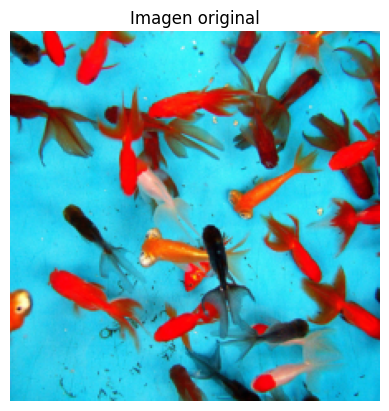

Aplicando FGSM...


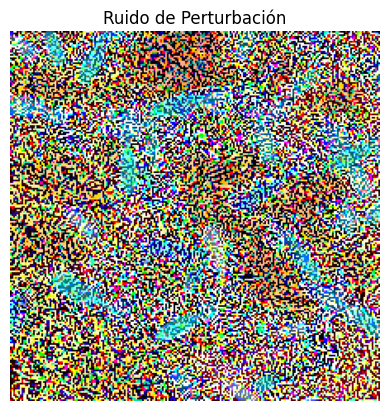

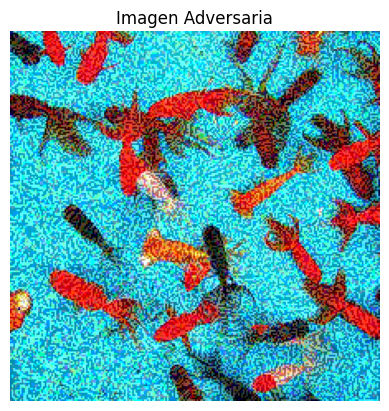

  0%|          | 0/5000 [00:00<?, ?it/s]


In [ ]:
mostrar_ataque('resnet', 'val.X', 1, 'fgsm', 13, 0.2)

Loading model: resnet, and dataset: val.X


  0%|          | 0/5000 [00:00<?, ?it/s]

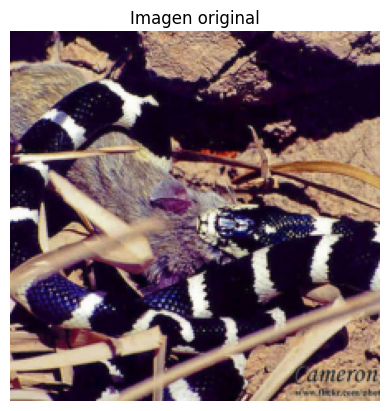

Aplicando PGD...


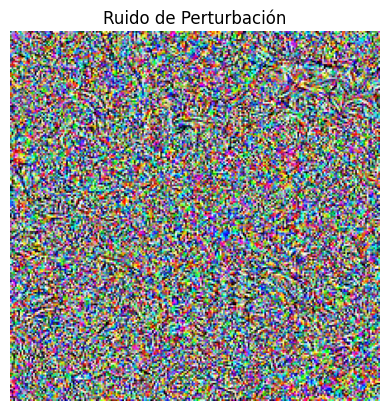

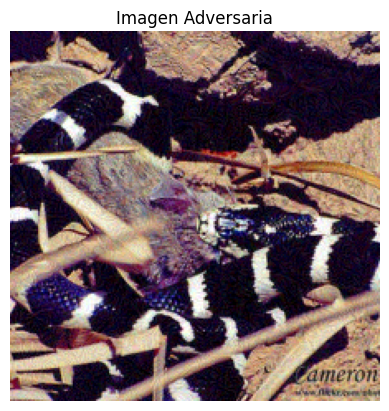

  0%|          | 0/5000 [00:01<?, ?it/s]


In [ ]:
mostrar_ataque('resnet', 'val.X', 1, 'pgd', 13, 0.3, 15/255, 20)

## Test

In [ ]:
basic_evaluate_model('resnet', 'val.X', 64)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]
100%|██████████| 79/79 [00:51<00:00,  1.53it/s]

Top 1 accuracy: 0.8622
Top 5 accuracy: 0.9728


In [32]:
attack_eval_model_on_single('resnet', 'val.X', 64, 'gauss', 13, 1, shuffle=True)

100%|██████████| 79/79 [00:49<00:00,  1.59it/s]

Top 1 accuracy: 0.4052
Top 5 accuracy: 0.6098


(0.4052, 0.6098)

In [17]:
attack_eval_model_on_single('resnet', 'val.X', 64, 'fgsm', 13, 0.2, shuffle=True)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]
100%|██████████| 79/79 [01:37<00:00,  1.23s/it]

Top 1 accuracy: 0.2526
Top 5 accuracy: 0.4472


(0.2526, 0.4472)

In [ ]:
attack_eval_model_on_single('resnet', 'val.X', 64, 'pgd', 13, 0.3, 8/255, 8)

100%|██████████| 79/79 [06:56<00:00,  5.27s/it]

Top 1 accuracy: 0.04
Top 5 accuracy: 0.086


(0.04, 0.086)

Evaluating model with epsilon: 0.05


100%|██████████| 79/79 [01:32<00:00,  1.17s/it]


Top 1 accuracy: 0.58
Top 5 accuracy: 0.7926
Evaluating model with epsilon: 0.1


100%|██████████| 79/79 [01:32<00:00,  1.18s/it]


Top 1 accuracy: 0.507
Top 5 accuracy: 0.7376
Evaluating model with epsilon: 0.15


100%|██████████| 79/79 [01:33<00:00,  1.18s/it]


Top 1 accuracy: 0.3798
Top 5 accuracy: 0.6078
Evaluating model with epsilon: 0.2


100%|██████████| 79/79 [01:33<00:00,  1.18s/it]


Top 1 accuracy: 0.2528
Top 5 accuracy: 0.4474
Evaluating model with epsilon: 0.25


100%|██████████| 79/79 [01:33<00:00,  1.18s/it]


Top 1 accuracy: 0.1264
Top 5 accuracy: 0.2782
Evaluating model with epsilon: 0.3


100%|██████████| 79/79 [01:33<00:00,  1.18s/it]


Top 1 accuracy: 0.0532
Top 5 accuracy: 0.1416


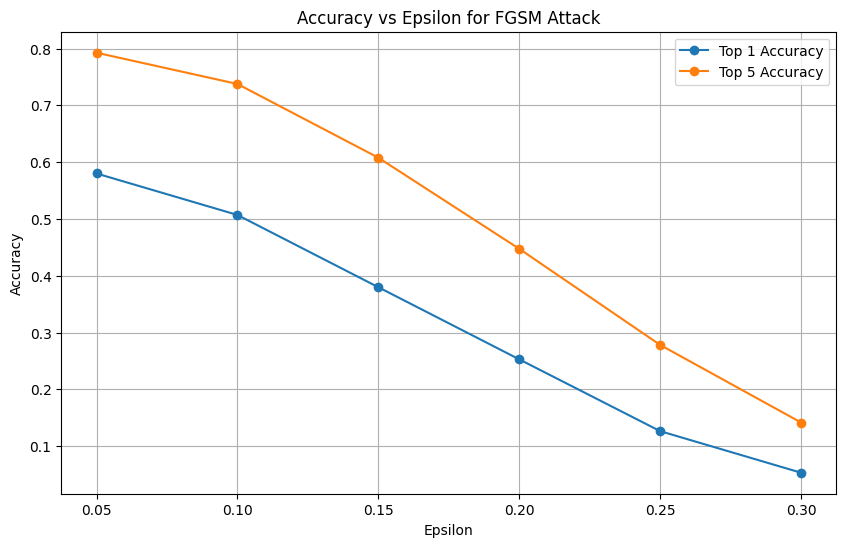

In [18]:
#@title Gráfico FGSM epsilon
# Function to loop over a list of epsilons and store accuracies
def attack_eval_model_multiple_epsilons(model='resnet', val_set='val.X', batch_size=64, atk_method='fgsm', epsilons=[0.1, 0.2, 0.3], alpha=5/255, its=43):
    epsilons_acc_top1 = []
    epsilons_acc_top5 = []

    # Loop over epsilon values
    for eps in epsilons:
        print(f'Evaluating model with epsilon: {eps}')
        acc_top1, acc_top5 = attack_eval_model_on_single(model, val_set, batch_size, atk_method, label=10, eps=eps, alpha=alpha, its=its)
        epsilons_acc_top1.append(acc_top1)
        epsilons_acc_top5.append(acc_top5)

    # Plot the results
    plot_accuracy_vs_epsilon(epsilons, epsilons_acc_top1, epsilons_acc_top5)

# Function to plot accuracy vs epsilon
def plot_accuracy_vs_epsilon(epsilons, acc_top1, acc_top5):
    plt.figure(figsize=(10,6))
    plt.plot(epsilons, acc_top1, label='Top 1 Accuracy', marker='o')
    plt.plot(epsilons, acc_top5, label='Top 5 Accuracy', marker='o')
    plt.title('Accuracy vs Epsilon for FGSM Attack')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
attack_eval_model_multiple_epsilons('resnet', 'val.X', 64, 'fgsm', epsilons)

For alpha = 2/255 and epsilon = 0.1:
Evaluating model with 1 iterations of PGD


100%|██████████| 79/79 [01:33<00:00,  1.18s/it]


Top 1 accuracy: 0.6064
Top 5 accuracy: 0.8252
Evaluating model with 3 iterations of PGD


100%|██████████| 79/79 [03:02<00:00,  2.31s/it]


Top 1 accuracy: 0.369
Top 5 accuracy: 0.5398
Evaluating model with 6 iterations of PGD


100%|██████████| 79/79 [05:17<00:00,  4.02s/it]


Top 1 accuracy: 0.1414
Top 5 accuracy: 0.2436
Evaluating model with 8 iterations of PGD


100%|██████████| 79/79 [06:41<00:00,  5.09s/it]


Top 1 accuracy: 0.0696
Top 5 accuracy: 0.1346
Evaluating model with 12 iterations of PGD


100%|██████████| 79/79 [09:37<00:00,  7.31s/it]


Top 1 accuracy: 0.024
Top 5 accuracy: 0.0482
Evaluating model with 15 iterations of PGD


100%|██████████| 79/79 [11:49<00:00,  8.99s/it]


Top 1 accuracy: 0.0142
Top 5 accuracy: 0.0276


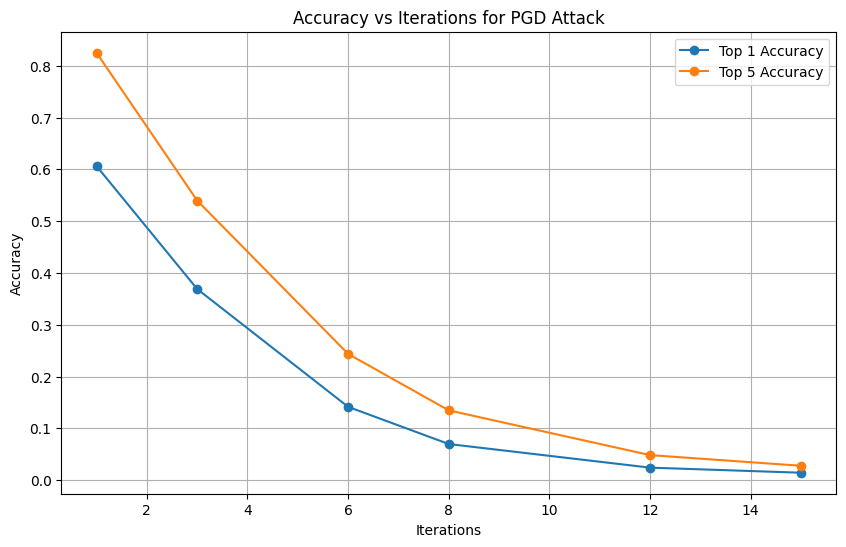

In [19]:
#@title Gráfico PGD iteraciones
# Function to loop over a list of iterations and store accuracies
def attack_eval_model_multiple_iterations(model='resnet', val_set='val.X', batch_size=64, atk_method='pgd', its_list=[1, 3, 6, 8, 12, 15], eps=0.1, alpha=5/255):
    iterations_acc_top1 = []
    iterations_acc_top5 = []

    # Loop over iteration values
    for its in its_list:
        print(f'Evaluating model with {its} iterations of PGD')
        acc_top1, acc_top5 = attack_eval_model_on_single(model, val_set, batch_size, atk_method, label=10, eps=eps, alpha=alpha, its=its)
        iterations_acc_top1.append(acc_top1)
        iterations_acc_top5.append(acc_top5)

    # Plot the results
    plot_accuracy_vs_iterations(its_list, iterations_acc_top1, iterations_acc_top5)

# Function to plot accuracy vs iterations
def plot_accuracy_vs_iterations(its_list, acc_top1, acc_top5):
    plt.figure(figsize=(10,6))
    plt.plot(its_list, acc_top1, label='Top 1 Accuracy', marker='o')
    plt.plot(its_list, acc_top5, label='Top 5 Accuracy', marker='o')
    plt.title('Accuracy vs Iterations for PGD Attack')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
iterations = [1, 3, 6, 8, 12, 15]
print('For alpha = 2/255 and epsilon = 0.1:')
attack_eval_model_multiple_iterations('resnet', 'val.X', 64, 'pgd', iterations)

Evaluating model with alpha: 0.00392156862745098


100%|██████████| 79/79 [08:08<00:00,  6.18s/it]


Top 1 accuracy: 0.1922
Top 5 accuracy: 0.308
Evaluating model with alpha: 0.00784313725490196


100%|██████████| 79/79 [08:08<00:00,  6.18s/it]


Top 1 accuracy: 0.0818
Top 5 accuracy: 0.1576
Evaluating model with alpha: 0.0196078431372549


100%|██████████| 79/79 [08:08<00:00,  6.18s/it]


Top 1 accuracy: 0.0364
Top 5 accuracy: 0.0788
Evaluating model with alpha: 0.0392156862745098


100%|██████████| 79/79 [08:08<00:00,  6.18s/it]


Top 1 accuracy: 0.0484
Top 5 accuracy: 0.0954
Evaluating model with alpha: 0.058823529411764705


100%|██████████| 79/79 [08:08<00:00,  6.19s/it]


Top 1 accuracy: 0.0614
Top 5 accuracy: 0.129


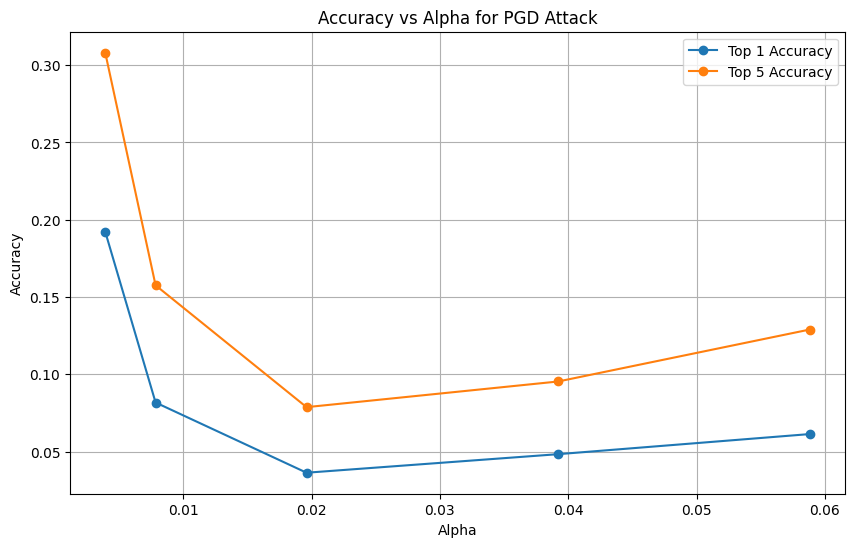

In [20]:
#@title Gráfico PGD alpha
# Function to loop over a list of alpha values and store accuracies
def attack_eval_model_multiple_alpha(model='resnet', val_set='val.X', batch_size=64, atk_method='pgd', alpha_list=[1/255, 2/255, 5/255, 10/255], eps=0.1, its=10):
    alpha_acc_top1 = []
    alpha_acc_top5 = []

    # Loop over alpha values
    for alpha in alpha_list:
        print(f'Evaluating model with alpha: {alpha}')
        acc_top1, acc_top5 = attack_eval_model_on_single(model, val_set, batch_size, atk_method, label=10, eps=eps, alpha=alpha, its=its)
        alpha_acc_top1.append(acc_top1)
        alpha_acc_top5.append(acc_top5)

    # Plot the results
    plot_accuracy_vs_alpha(alpha_list, alpha_acc_top1, alpha_acc_top5)

# Function to plot accuracy vs alpha
def plot_accuracy_vs_alpha(alpha_list, acc_top1, acc_top5):
    plt.figure(figsize=(10,6))
    plt.plot(alpha_list, acc_top1, label='Top 1 Accuracy', marker='o')
    plt.plot(alpha_list, acc_top5, label='Top 5 Accuracy', marker='o')
    plt.title('Accuracy vs Alpha for PGD Attack')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
alpha_values = [1/255, 2/255, 5/255, 10/255, 15/255]
attack_eval_model_multiple_alpha('resnet', 'val.X', 64, 'pgd', alpha_values)

## Debug

In [ ]:
#@title FGSMdebug

def unnormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(image.device)
    return image * std + mean
def renorm(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(image.device)
    return (image-mean)/std

def fgsm(input, grad, epsilon):
  """
  Adds FGSM noise to input
  """
  # find elementwise signs of gradient
  signs = grad.sign()
  # apply FGSM perturbation according to paper
  perturbed_input = input + epsilon * signs
  # The PILToTensor method in pytoch sets all the values to be in the range
  #   [0, 1], so we apply a clamp such that this range is maintained
  return torch.clamp(perturbed_input, 0, 1)


def FGSMDirigidoBatchDebug(imagenes, modelo, epsilon, labels, mapped_indices, imgnet100_labels, imgnet1k_labels, clamp=True):
    # set model a inferencia


    # mapear labels
    mapped_labels = [mapped_indices[label.item()] for label in labels]
    # labels a tensor
    mapped_labels_tensor = torch.tensor(mapped_labels, dtype=torch.long).to(device)
    print(f"Dimensiones de los labels mapeados: {mapped_labels_tensor.shape}")
    copias = imagenes
    # crear copia de las imágenes para no alterar las reales
    copias.requires_grad = True
    print(f"Dimensiones de las imágenes de entrada: {copias.shape}")
    print(f"Valores de las imágenes - max: {copias.max().item()}, min: {copias.min().item()}")
    # hacer gradientes 0
    modelo.zero_grad()


    # forward para obtener predicciones/logits
    predicciones = modelo(copias)
    print(f"Dimensiones de los logits/predicciones: {predicciones.shape}")
    print(f"Valores de las predicciones - max: {predicciones.max().item()}, min: {predicciones.min().item()}")
    # calcular loss para todo el batch
    loss = torch.nn.functional.cross_entropy(predicciones, mapped_labels_tensor)
    print(f"Valor de la loss: {loss.item()}")

    # backward para calcular gradientes para el batch
    loss.backward()

    # obtener los gradientes
    gradientes = copias.grad
    print(f"Dimensiones de los gradientes: {gradientes.shape}")
    print(f"Valores de los gradientes - max: {gradientes.max().item()}, min: {gradientes.min().item()}")
    imagenes_adv = unnormalize_image(copias)
    print(f"Denorm - max: {imagenes_adv.max().item()}, min: {imagenes_adv.min().item()}")
    imagenes_adv = fgsm(imagenes_adv, gradientes, epsilon)
    print(f"after attack - max: {imagenes_adv.max().item()}, min: {imagenes_adv.min().item()}")
    imagenes_adv = renorm(imagenes_adv)
    print(f"renorm - max: {imagenes_adv.max().item()}, min: {imagenes_adv.min().item()}")

    print(f"Dimensiones de las imágenes adversarias: {imagenes_adv.shape}")
    print(f"Valores de las imágenes adversarias - max: {imagenes_adv.max().item()}, min: {imagenes_adv.min().item()}")

    return imagenes_adv



In [ ]:
#@title Debugger
def debugger(model='str', val_set='val.X', batch_size=1, atk_method='str', label=10, eps=0.1, alpha=5/255, its=43, clamp=True, shuffle=False):
    global device
    model, test_loader = load_model_and_dataloader(model, val_set, batch_size, shuffle)
    imgnet1k_labels, imgnet100_labels, mapped_indices = get_labels()

    correct = 0
    correct_5 = 0
    total = 0

    for x, y in tqdm(test_loader):
        x = x.to(device)  # batch a device
        x.requires_grad = True
        print(f"Dimensiones del batch de entrada: {x.shape}")
        print(f"Valores del batch de entrada - max: {x.max().item()}, min: {x.min().item()}")
        model.eval()
        # seleccionar método
        if atk_method.lower() == 'fgsm':
            x_adv = FGSMDirigidoBatchDebug(x, model, eps, y, mapped_indices, imgnet100_labels, imgnet1k_labels, clamp)
        elif atk_method.lower() == 'pgd':
            x_adv = pgd_attackBatch(x, model, y, eps, alpha, its, mapped_indices, imgnet100_labels, imgnet1k_labels, clamp)

        print(f"Dimensiones del batch de imágenes adversarias: {x_adv.shape}")
        print(f"Valores de las imágenes adversarias - max: {x_adv.max().item()}, min: {x_adv.min().item()}")
        break

debugger('resnet', 'val.X', 1, 'fgsm', 13, 0.2, clamp=True)


Loading model: resnet, and dataset: val.X


  0%|          | 0/5000 [00:00<?, ?it/s]

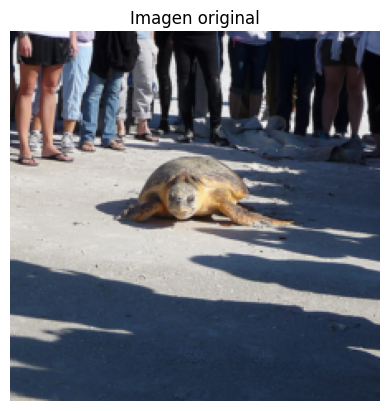

Applying FGSM...
Dimensiones de los labels mapeados: torch.Size([1])
Dimensiones de las imágenes de entrada: torch.Size([1, 3, 224, 224])
Valores de las imágenes - max: 2.6225709915161133, min: -2.1007792949676514
Dimensiones de los logits/predicciones: torch.Size([1, 1000])
Valores de las predicciones - max: 6.2338361740112305, min: -1.1051448583602905
Valor de la loss: 1.326314926147461
Dimensiones de los gradientes: torch.Size([1, 3, 224, 224])
Valores de los gradientes - max: 0.22617675364017487, min: -0.27774468064308167
Denorm - max: 0.9960784912109375, min: 0.003921538591384888
after attack - max: 1.0, min: 0.0
renorm - max: 2.640000104904175, min: -2.1179039478302
Dimensiones de las imágenes adversarias: torch.Size([1, 3, 224, 224])
Valores de las imágenes adversarias - max: 2.640000104904175, min: -2.1179039478302


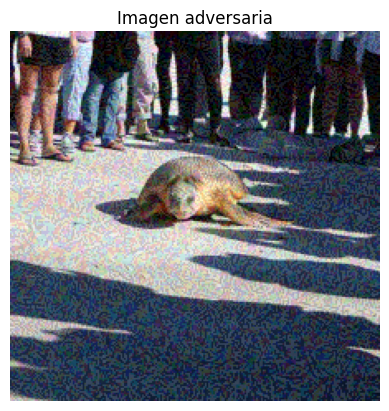

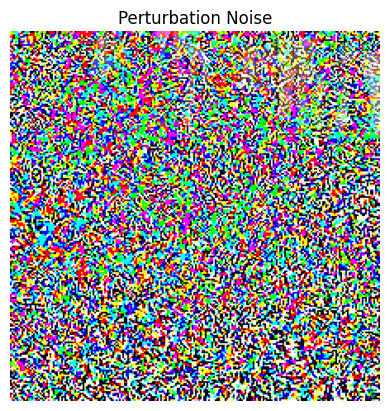

  0%|          | 0/5000 [00:00<?, ?it/s]


In [ ]:


def unnormalize_image(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(batch.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(batch.device)
    unnormalized = batch * std + mean
    return torch.clamp(unnormalized, 0, 1)


def show_image_with_matplotlib(tensor, title=""):
    tensor = unnormalize_image(tensor).squeeze(0).cpu()


    image = tensor.permute(1, 2, 0).detach().numpy()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


def show_perturbation(perturbation, title="Perturbation Noise"):

    perturbation = perturbation.squeeze(0).cpu()
    perturbation = perturbation.permute(1, 2, 0).detach().numpy()

    perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())

    plt.imshow(perturbation)
    plt.title(title)
    plt.axis('off')
    plt.show()

#@title Debugger plot con perturbación
def debugger(model='str', val_set='val.X', batch_size=1, atk_method='str', label=10, eps=0.1, alpha=5/255, its=43, shuffle=False):
    global device
    print(f"Loading model: {model}, and dataset: {val_set}")
    model, test_loader = load_model_and_dataloader(model, val_set, batch_size, shuffle)
    imgnet1k_labels, imgnet100_labels, mapped_indices = get_labels()

    for x, y in tqdm(test_loader):
        x = x.to(device)
        x.requires_grad = True


        show_image_with_matplotlib(x, title="Imagen original")


        if atk_method.lower() == 'fgsm':
            print("Applying FGSM...")
            x_adv = FGSMDirigidoBatchDebug(x, model, eps, y, mapped_indices, imgnet100_labels, imgnet1k_labels)
        elif atk_method.lower() == 'pgd':
            print("Applying PGD...")
            x_adv = pgd_attackBatch(x, model, y, eps, alpha, its, mapped_indices, imgnet100_labels, imgnet1k_labels)


        perturbation = x_adv - x

        show_perturbation(perturbation, title="Perturbation Noise")

        show_image_with_matplotlib(x_adv, title="Imagen adversaria")



        break


debugger('resnet', 'val.X', 1, 'fgsm', 13, 0.07)

